<a href="https://colab.research.google.com/github/jackgrebenc/YCbCr_RGB_CAE/blob/main/YCbCr_RGB_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
from torchvision.utils import save_image
import torchvision.utils as vutils
from torchsummary import summary
from IPython import display

%matplotlib inline

In [2]:
# Configurations
dataroot = "./data"

image_size = 128
nb_channls=1 # 3 for RGB images
workers=4
num_epochs = 20
batch_size = 32
learning_rate = 1e-4
weight_decay = 1e-5

#CHOOSE either grayscale, Ycbcr or RGB image format
#option = 'grayscale'
option = 'Ycbcr'
#option = 'RGB'

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

    
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), nb_channls, image_size, image_size)
    return x

device

device(type='cuda', index=0)

In [3]:
#Define conversions from RGB to YCbCr
# RGB [0,1] <-> YCbCr [0,1] in both cases
class RGB2YCbCr_Transform(object):
    def __call__(self,input):
      #Convert RGB image tensors in range[0,1] to YCbCr
     # input is a single image 3 x H x W 
      output = Variable(input.data.new(*input.size()))
      output[0, :, :] = input[0, :, :] *0.299 + input[1, :, :] *0.587 + input[2, :, :] *0.114 #Y in range [0, 1]
      output[1, :, :] = input[0, :, :] *(-0.168736) - input[1, :, :] *0.331264 + input[2, :, :] *0.5 +0.5 #Cb in range [0,1]
      output[2, :, :] = input[0, :, :] *0.5 - input[1, :, :] *0.418688 - input[2, :, :] *0.081312 +0.5 #Cr in range [0, 1]
      return output #output YCbCr all on range [0,1]

class YCbCr2RGB(object):
  def __call__(self, input):
    #Converts a denormalized YCbCr image Y [0,1] and Cb/Cr in range [0,1]
    #This operation is performed on the minibatches rather than individual images done in RGB2YCbCr_Transform
    output = Variable(input.data.new(*input.size()))
    output[:,0, :, :] = input[:,0, :, :] - (input[:,1, :, :] -0.5) *0.0009 + (input[:,2, :, :] -0.5) *1.4017  #R in range [0,1]
    output[:,1, :, :] = input[:,0, :, :] - (input[:,1, :, :] -0.5) *0.3437 - (input[:,2, :, :] -0.5) *0.7142 #G in range [0,1]
    output[:,2, :, :] = input[:,0, :, :] + (input[:,1, :, :]-0.5)*1.7722 + (input[:,2, :, :]-0.5) *0.0010 #B in range [0,1]
    return output


In [4]:
# Load Dataset
# Download Dataset
from torch.utils.data.sampler import SubsetRandomSampler
#Colour

if option == 'grayscale':
  #Grayscale
  print("USING GRAYSCALE IMAGES")
  transform=transforms.Compose([ transforms.Grayscale(num_output_channels=1),
                               transforms.Resize((image_size, image_size)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5), (0.5))])
elif option == 'Ycbcr':
  print("USING YCbCr COLOUR IMAGES")
  transform =transforms.Compose([transforms.Resize((image_size, image_size)),
                               transforms.ToTensor(),
                               RGB2YCbCr_Transform()])
else:
  print("USING RGB COLOUR IMAGES")
  transform =transforms.Compose([transforms.Resize((image_size, image_size)),
                               transforms.ToTensor()])
                               #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]) #Normalize using ImageNet means and standard deviations for 

#Loading CIFAR-100

train_set = datasets.CIFAR100(root='./data',
                            train=True,
                            download=True, transform=transform
                           )
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

test_set = datasets.CIFAR100(root='./data',
                            train=False,
                            download=True, transform=transform
                           )
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=workers)


USING YCbCr COLOUR IMAGES
Files already downloaded and verified
Files already downloaded and verified


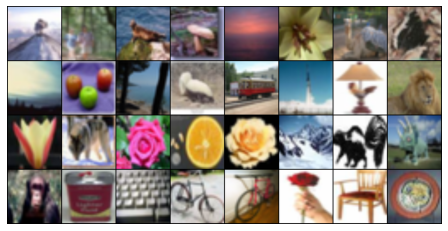

In [5]:
# Preview some images in dataset
if option == 'grayscale' or option == 'RGB' :
  #Ignore YCbCr transform, since images are grayscale
  batch = test_loader.__iter__().next()
else:
  convert = YCbCr2RGB()
  batch = test_loader.__iter__().next()
  batch[0] = convert(batch[0])

#Show one batch of test images 
plt.figure(figsize=(8,4))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(batch[0].to(device)[:32], padding=2, normalize=True).cpu(),(1,2,0)))

In [6]:
#Define Model -- Same architecture for all three components, however different networks will be used
#Model 1 
class autoencoder(nn.Module):
  def __init__(self,component):
    super(autoencoder, self).__init__()
    self.component = component
    #Input is one channel of Y, Cb or Cr channel -> Size 1x128x128
    self.downSample = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(3,3), padding=1, stride=1),
        nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(3,3), padding=1, stride=2),
        nn.PReLU()
    )
    self.upSample = nn.Sequential(
        nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=(3,3), stride=1, padding=1),
        nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=(4,4), stride=2, padding=1),
        nn.PReLU()
    )
  def forward(self, x):
    x = self.downSample(x)
    x = self.downSample(x)
    x = self.downSample(x)
    embedding = x
    x = self.upSample(x)
    x = self.upSample(x)
    x = self.upSample(x)
    x = nn.Tanh()(x) #Chroma components respond better to ReLU
    return x

#Model 2 - inspired by "PlaywithEncoders"
'''
class autoencoder(nn.Module):
    def __init__(self,component):
        
        super(autoencoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 9, kernel_size=(5,5),padding=2)
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2,2), return_indices=True)
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2,2), return_indices=True)
        self.maxpool3 = nn.MaxPool2d(kernel_size=(4,4), return_indices=True)
        self.maxpool4 = nn.MaxPool2d(kernel_size=(4,4), return_indices=True)
        self.unconv1 = nn.ConvTranspose2d(9,1,kernel_size=(5,5),padding=2)
        self.maxunpool1 = nn.MaxUnpool2d(kernel_size=(2,2))
        self.maxunpool2 = nn.MaxUnpool2d(kernel_size=(2,2))
        self.maxunpool3 = nn.MaxUnpool2d(kernel_size=(4,4))
        self.maxunpool4 = nn.MaxUnpool2d(kernel_size=(4,4))
        
        self.encoder1 = nn.Sequential(
            nn.Tanh(),
            nn.Conv2d(9, 27,kernel_size=(5,5),padding=2),
        )
        
        self.encoder2 = nn.Sequential(
            nn.Tanh(),
            nn.Conv2d(27, 81, kernel_size=(5,5), padding=2),
        )
        
        self.encoder3 = nn.Sequential(
            nn.LeakyReLU(),
            nn.Conv2d(81, 128, kernel_size=(5,5), padding=2)
        )
        self.encoder4 = nn.Sequential(
            nn.Tanh(),
            nn.Conv2d(128,256,kernel_size=(5,5),padding=2),
            nn.Tanh()
        )
        self.encoder5 = nn.Sequential(
            nn.Linear(in_features=1024, out_features=128),
            nn.LeakyReLU()
        )
        self.decoder5 = nn.Sequential(
            nn.Linear(in_features=128, out_features=1024),
            nn.Tanh()
        )
        self.decoder4 = nn.Sequential(
            nn.ConvTranspose2d(256,128,kernel_size=(5,5), padding=2),
            nn.Tanh()
        )
        self.decoder3 = nn.Sequential(
            nn.ConvTranspose2d(128, 81, kernel_size=(5,5),padding=2),
            nn.LeakyReLU()
        )
        
        self.decoder2 = nn.Sequential(
            nn.ConvTranspose2d(81, 27, kernel_size=(5,5),padding=2),
            nn.Tanh()
        )
        
        self.decoder1 = nn.Sequential(
            nn.ConvTranspose2d(27,9,kernel_size=(5,5), padding=2),
            nn.Tanh(),
        )
        

    def forward(self, x):
        # Encoder
        x = self.conv1(x)
        x,indices1 = self.maxpool1(x)
        x = self.encoder1(x)
        x,indices2 = self.maxpool2(x)
        x = self.encoder2(x)
        x,indices3 = self.maxpool3(x)
        x = self.encoder3(x)
        x, indices4 = self.maxpool4(x)
        x = self.encoder4(x)
        x = torch.flatten(x,start_dim=1)
        x = self.encoder5(x)
        
        # Decoder
        x = self.decoder5(x)
        x = torch.reshape(x, (-1,256,2,2))
        x = self.decoder4(x)
        x = self.maxunpool4(x,indices4)
        x = self.decoder3(x)
        x = self.maxunpool3(x, indices3)
        x = self.decoder2(x)
        x = self.maxunpool2(x, indices2)
        x = self.decoder1(x)
        x = self.maxunpool1(x,indices1)
        x = self.unconv1(x)
        x = nn.Tanh()(x)
        return x
'''

'\nclass autoencoder(nn.Module):\n    def __init__(self,component):\n        \n        super(autoencoder, self).__init__()\n        self.conv1 = nn.Conv2d(1, 9, kernel_size=(5,5),padding=2)\n        self.maxpool1 = nn.MaxPool2d(kernel_size=(2,2), return_indices=True)\n        self.maxpool2 = nn.MaxPool2d(kernel_size=(2,2), return_indices=True)\n        self.maxpool3 = nn.MaxPool2d(kernel_size=(4,4), return_indices=True)\n        self.maxpool4 = nn.MaxPool2d(kernel_size=(4,4), return_indices=True)\n        self.unconv1 = nn.ConvTranspose2d(9,1,kernel_size=(5,5),padding=2)\n        self.maxunpool1 = nn.MaxUnpool2d(kernel_size=(2,2))\n        self.maxunpool2 = nn.MaxUnpool2d(kernel_size=(2,2))\n        self.maxunpool3 = nn.MaxUnpool2d(kernel_size=(4,4))\n        self.maxunpool4 = nn.MaxUnpool2d(kernel_size=(4,4))\n        \n        self.encoder1 = nn.Sequential(\n            nn.Tanh(),\n            nn.Conv2d(9, 27,kernel_size=(5,5),padding=2),\n        )\n        \n        self.encoder2 =

In [7]:
#Model 3 - Complex model from Lossy Image Compression with Compressive Autoencoders 
'''
class autoencoder(nn.Module):
    """
    This AE module will be fed 3x128x128 patches from the original image
    Shapes are (batch_size, channels, height, width)
    Latent representation: 32x32x32 bits per patch => 240KB per image (for 720p)
    """

    def __init__(self,component):
        super(autoencoder, self).__init__()

        self.encoded = None
        self.component = component
        # ENCODER

        # 64x64x64
        self.e_conv_1 = nn.Sequential(
            nn.ZeroPad2d((1, 2, 1, 2)),
            nn.Conv2d(
                in_channels=1, out_channels=64, kernel_size=(5, 5), stride=(2, 2)
            ),
            nn.LeakyReLU(),
        )

        # 128x32x32
        self.e_conv_2 = nn.Sequential(
            nn.ZeroPad2d((1, 2, 1, 2)),
            nn.Conv2d(
                in_channels=64, out_channels=128, kernel_size=(5, 5), stride=(2, 2)
            ),
            nn.LeakyReLU(),
        )

        # 128x32x32
        self.e_block_1 = nn.Sequential(
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(
                in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)
            ),
            nn.LeakyReLU(),
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(
                in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)
            ),
        )

        # 128x32x32
        self.e_block_2 = nn.Sequential(
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(
                in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)
            ),
            nn.LeakyReLU(),
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(
                in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)
            ),
        )

        # 128x32x32
        self.e_block_3 = nn.Sequential(
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(
                in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)
            ),
            nn.LeakyReLU(),
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(
                in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)
            ),
        )

        # 32x32x32
        self.e_conv_3 = nn.Sequential(
            nn.Conv2d(
                in_channels=128,
                out_channels=32,
                kernel_size=(5, 5),
                stride=(1, 1),
                padding=(2, 2),
            ),
            nn.Tanh(),
        )

        # DECODER

        # 128x64x64
        self.d_up_conv_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=32, out_channels=64, kernel_size=(3, 3), stride=(1, 1)
            ),
            nn.LeakyReLU(),
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.ConvTranspose2d(
                in_channels=64, out_channels=128, kernel_size=(2, 2), stride=(2, 2)
            ),
        )

        # 128x64x64
        self.d_block_1 = nn.Sequential(
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(
                in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)
            ),
            nn.LeakyReLU(),
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(
                in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)
            ),
        )

        # 128x64x64
        self.d_block_2 = nn.Sequential(
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(
                in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)
            ),
            nn.LeakyReLU(),
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(
                in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)
            ),
        )

        # 128x64x64
        self.d_block_3 = nn.Sequential(
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(
                in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)
            ),
            nn.LeakyReLU(),
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(
                in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)
            ),
        )

        # 256x128x128
        self.d_up_conv_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=128, out_channels=32, kernel_size=(3, 3), stride=(1, 1)
            ),
            nn.LeakyReLU(),
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.ConvTranspose2d(
                in_channels=32, out_channels=256, kernel_size=(2, 2), stride=(2, 2)
            ),
        )

        # 3x128x128
        self.d_up_conv_3 = nn.Sequential(
            nn.Conv2d(
                in_channels=256, out_channels=16, kernel_size=(3, 3), stride=(1, 1)
            ),
            nn.LeakyReLU(),
            nn.ReflectionPad2d((2, 2, 2, 2)),
            nn.Conv2d(
                in_channels=16, out_channels=1, kernel_size=(3, 3), stride=(1, 1)
            ),
            nn.Tanh(),
        )

    def forward(self, x):
        ec1 = self.e_conv_1(x)
        ec2 = self.e_conv_2(ec1)
        eblock1 = self.e_block_1(ec2) + ec2
        eblock2 = self.e_block_2(eblock1) + eblock1
        eblock3 = self.e_block_3(eblock2) + eblock2
        ec3 = self.e_conv_3(eblock3)  # in [-1, 1] from tanh activation

        # stochastic binarization
        with torch.no_grad():
            rand = torch.rand(ec3.shape).cuda()
            prob = (1 + ec3) / 2
            eps = torch.zeros(ec3.shape).cuda()
            eps[rand <= prob] = (1 - ec3)[rand <= prob]
            eps[rand > prob] = (-ec3 - 1)[rand > prob]

        # encoded tensor
        self.encoded = 0.5 * (ec3 + eps + 1)  # (-1|1) -> (0|1)

        return self.decode(self.encoded)

    def decode(self, encoded):
        y = encoded * 2.0 - 1  # (0|1) -> (-1|1)

        uc1 = self.d_up_conv_1(y)
        dblock1 = self.d_block_1(uc1) + uc1
        dblock2 = self.d_block_2(dblock1) + dblock1
        dblock3 = self.d_block_3(dblock2) + dblock2
        uc2 = self.d_up_conv_2(dblock3)
        dec = self.d_up_conv_3(uc2)

        return dec
    def get_component(self):
      return self.component #return the string that specifices the component the network is trained on
'''

'\nclass autoencoder(nn.Module):\n    """\n    This AE module will be fed 3x128x128 patches from the original image\n    Shapes are (batch_size, channels, height, width)\n    Latent representation: 32x32x32 bits per patch => 240KB per image (for 720p)\n    """\n\n    def __init__(self,component):\n        super(autoencoder, self).__init__()\n\n        self.encoded = None\n        self.component = component\n        # ENCODER\n\n        # 64x64x64\n        self.e_conv_1 = nn.Sequential(\n            nn.ZeroPad2d((1, 2, 1, 2)),\n            nn.Conv2d(\n                in_channels=1, out_channels=64, kernel_size=(5, 5), stride=(2, 2)\n            ),\n            nn.LeakyReLU(),\n        )\n\n        # 128x32x32\n        self.e_conv_2 = nn.Sequential(\n            nn.ZeroPad2d((1, 2, 1, 2)),\n            nn.Conv2d(\n                in_channels=64, out_channels=128, kernel_size=(5, 5), stride=(2, 2)\n            ),\n            nn.LeakyReLU(),\n        )\n\n        # 128x32x32\n        self

In [8]:
# Compile Networks - Three seperate models for each channel in YCbCr
model_Y = autoencoder("Y").to(device)
model_Cb = autoencoder("Cb").to(device)
model_Cr = autoencoder("Cr").to(device)
optimizer = torch.optim.Adam(
    model_Y.parameters(), lr=1e-4, weight_decay=weight_decay)
optimizer_Cb = torch.optim.Adam(
    model_Cb.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer_Cr = torch.optim.Adam(
    model_Cr.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.MSELoss(reduction='mean')
summary(model_Y, (nb_channls, image_size, image_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 1, 128, 128]              10
            Conv2d-2            [-1, 1, 64, 64]              10
             PReLU-3            [-1, 1, 64, 64]               1
            Conv2d-4            [-1, 1, 64, 64]              10
            Conv2d-5            [-1, 1, 32, 32]              10
             PReLU-6            [-1, 1, 32, 32]               1
            Conv2d-7            [-1, 1, 32, 32]              10
            Conv2d-8            [-1, 1, 16, 16]              10
             PReLU-9            [-1, 1, 16, 16]               1
  ConvTranspose2d-10            [-1, 1, 16, 16]              10
  ConvTranspose2d-11            [-1, 1, 32, 32]              17
            PReLU-12            [-1, 1, 32, 32]               1
  ConvTranspose2d-13            [-1, 1, 32, 32]              10
  ConvTranspose2d-14            [-1, 1,

In [9]:
#Train three different identical networks on each Y Cb and Cr component

#First try just training the Y
iter = 0
model_Y.train()
model_Cb.train()
model_Cr.train()

#Track Losses for each network and total
epoch_lis = []
loss_lis = []
loss_Cb_lis = []
loss_Cr_lis = []
iteration=0
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        try:
          #-----Model #1 - Y COMPONENT--------
          y_component = img[:,0:1, :,:]
          y_component = Variable(y_component).to(device)
          # Forward
          output = model_Y(y_component)
          loss = criterion(output, y_component)

          # Backprop
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          if option != 'grayscale':
            #-----Model #2 - Cb COMPONENT--------
            cb_component = img[:,1:2, :,:]
            cb_component = Variable(cb_component).to(device)
            # Forward
            output_Cb = model_Cb(cb_component)
            loss_Cb = criterion(output_Cb, cb_component)

            # Backprop
            optimizer_Cb.zero_grad()
            loss_Cb.backward()
            optimizer_Cb.step()

            #-----Model #3 - Cr COMPONENT--------
            cr_component = img[:,2:3, :,:]
            cr_component = Variable(cr_component).to(device)
            # Forward
            output_Cr = model_Cr(cr_component)
            loss_Cr = criterion(output_Cr, cr_component)

            # Backprop
            optimizer_Cr.zero_grad()
            loss_Cr.backward()
            optimizer_Cr.step()
          #Every 50 iterations - update loss lists for graphing
          if iteration % 50 == 0:
            if option == 'grayscale':
              epoch_lis.append(loss.item())
            else:
              epoch_loss = (loss.item() + loss_Cb.data.item() + loss_Cr.item())/3
              epoch_lis.append(epoch_loss)
              loss_lis.append(loss.item())
              loss_Cb_lis.append(loss_Cb.item())
              loss_Cr_lis.append(loss_Cr.item())
          iteration += 1
        except:
          print("Error at iteration ", iteration)
          break
    if option != 'grayscale':
      print('epoch [{}/{}], loss:{:.8f},{:.8f},{:.8f}'
          .format(epoch + 1, num_epochs, loss.item(), loss_Cb.item(), loss_Cr.item()))
    else:
      #grayscale -> only has one loss
      print('epoch [{}/{}], loss:{:.8f}'
          .format(epoch + 1, num_epochs, loss.item())) 
      
      


epoch [1/20], loss:0.08542825,0.00612458,0.00749256
epoch [2/20], loss:0.02638165,0.00548802,0.00541517
epoch [3/20], loss:0.01607880,0.00845632,0.00652235
epoch [4/20], loss:0.01092211,0.00773325,0.00453767
epoch [5/20], loss:0.00792237,0.00560949,0.00282359
epoch [6/20], loss:0.00411290,0.00392834,0.00156080
epoch [7/20], loss:0.00430673,0.00183124,0.00093016
epoch [8/20], loss:0.00262272,0.00135641,0.00081191
epoch [9/20], loss:0.00244809,0.00110088,0.00069612
epoch [10/20], loss:0.00231571,0.00069751,0.00049244
epoch [11/20], loss:0.00258361,0.00046107,0.00062469
epoch [12/20], loss:0.00243840,0.00039198,0.00028360
epoch [13/20], loss:0.00221027,0.00035560,0.00026512
epoch [14/20], loss:0.00215234,0.00038915,0.00042799
epoch [15/20], loss:0.00177890,0.00018241,0.00022395
epoch [16/20], loss:0.00178888,0.00019016,0.00027718
epoch [17/20], loss:0.00205341,0.00018572,0.00018628
epoch [18/20], loss:0.00195936,0.00016364,0.00012119
epoch [19/20], loss:0.00182718,0.00021618,0.00020735
ep

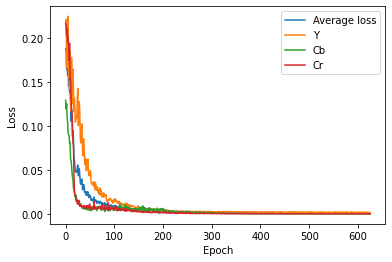

In [10]:
#Plot losses
plt.plot(epoch_lis, label='Average loss')
if option == 'Ycbcr':
  plt.plot(loss_lis, label='Y')
  plt.plot(loss_Cb_lis, label ='Cb')
  plt.plot(loss_Cr_lis, label='Cr')
if option =='RGB':
  plt.plot(loss_lis, label='R')
  plt.plot(loss_Cb_lis, label ='G')
  plt.plot(loss_Cr_lis, label='B')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss:0.00138294,0.00011242,0.00009970
Formating for Ycbcr...


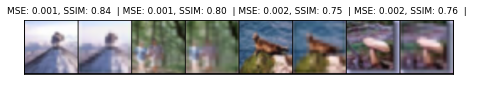

In [11]:
#Evaluate performance by printing images and comparing to the original
with torch.no_grad():
  m_batch_size = 4 #modified batch size for validation
  model_Y.eval()
  model_Cb.eval()
  model_Cr.eval()
  test_data = next(test_loader.__iter__())
  test_img, _ = test_data
  test_img = test_img[:m_batch_size] #take only the first four images of the batch
  #Y component
  y_comp = test_img[:,0:1,:,:]
  y_comp = Variable(y_comp).to(device)
  test_output_1 = model_Y(y_comp)
  loss_1 = criterion(test_output_1, y_comp)
  if option != 'grayscale':
    #Cb component
    cb_comp = test_img[:,1:2,:,:]
    cb_comp = Variable(cb_comp).to(device)
    test_output_2 = model_Cb(cb_comp)
    loss_2 = criterion(test_output_2, cb_comp)

    #Cr component
    cr_comp = test_img[:,2:3,:,:]
    cr_comp = Variable(cr_comp).to(device)
    test_output_3 = model_Cr(cr_comp)
    loss_3 = criterion(test_output_3, cr_comp)
    print('loss:{:.8f},{:.8f},{:.8f}'
            .format(loss_1, loss_2, loss_3))


    reconstructed = torch.empty(m_batch_size, 3, image_size, image_size) #reconstruct the 3 channels
    reconstructed[:,0:1,:,:] = test_output_1
    reconstructed[:,1:2,:,:] = test_output_2
    reconstructed[:,2:3,:,:] = test_output_3 #the stacked output of the three networks
    
    total_loss = criterion(reconstructed, test_img)
  else:
    #gray scale
    reconstructed = torch.empty(m_batch_size, 1, image_size, image_size) #reconstruct the grayscale channel
    reconstructed[:,0:1,:,:] = test_output_1

  # Preview some images and performance in the test set
  if option == 'Ycbcr':
    print("Formating for Ycbcr...")
    convert = YCbCr2RGB()
    test_img = convert(test_img)
    reconstructed = torch.clamp(reconstructed, -0.5, 1.0)
    reconstructed = convert(reconstructed)


  test_pic = reconstructed
  test_pic_orig = test_img
  btch_list = []
  ssim_mse = ''
  from skimage.metrics import structural_similarity as ssim
  from skimage.metrics import mean_squared_error

  label = 'MSE: {:.3f}, SSIM: {:.2f}  | '
  for i in range(test_pic.shape[0]):
    btch_list.append(test_pic_orig[i:i+1,:,:,:])
    btch_list.append((test_pic[i:i+1,:,:,:]))
    o_img = np.transpose(torch.reshape(test_pic_orig[i:i+1,:,:,:], (3,128,128)), (1,2,0)).numpy()
    r_img = np.transpose(torch.reshape(test_pic[i:i+1,:,:,:], (3,128,128)), (1,2,0)).numpy()
    ssim_res = ssim(o_img, r_img,data_range=r_img.max() - r_img.min(),multichannel=True)
    mse_res = mean_squared_error(o_img,r_img)
    ssim_mse += label.format(mse_res, ssim_res)
  btch = torch.cat(btch_list)
  fig = plt.figure( figsize=(8,1))
  btch = btch.to(device)[:8]
  ax = plt.imshow(np.transpose(vutils.make_grid(btch, padding=2).cpu(),(1,2,0)))
  ax.axes.get_xaxis().set_visible(False)
  ax.axes.get_yaxis().set_visible(False)
  ax.axes.set_title(ssim_mse,fontdict={'fontsize': 9, 'fontweight': 'medium'})
  plt.show(fig)

  #Test an image SSIM

In [12]:
#Calculate various metrics
#PSNR calculation 
import cv2
psnr_list = []
for i in range(0, len(btch_list), 2):
  #even ranges -> original, odd number -> reconstructed
  original = btch_list[i].numpy().reshape(3,image_size, image_size)
  original = np.transpose(original, (1,2,0))
  compressed = btch_list[i+1].numpy().reshape(3,image_size, image_size)
  compressed= np.transpose(compressed, (1,2,0))

  psnr = cv2.PSNR(compressed, original)
  psnr = round(psnr,2)
  psnr_list.append(psnr)

print(psnr_list) #These are very high, which indicates a good reconstruction (although the representation is > 8 bits)

#Display Compression Ratio

#1) CAE Model
#Stored: 32,768 bits (32x32x32 bits)
#Original: 393,216 bits (3x128x128x8 bits)
#--> Compression ratio of 12:1

#BPP: 16384 pixels/32,768 bits = 0.5 bpp



[76.87, 77.14, 75.23, 75.01]
